<a href="https://colab.research.google.com/github/anyavoitovich/data_science/blob/main/automl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret

In [ ]:
!pip install mlflow


In [ ]:
!pip install pyngrok

In [ ]:
!ngrok authtoken 2d2sgQEsI7ROh0VTnP27yyaR40k_6dMCGbbrqLUXMxHYtrmfg

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


1 способ

In [ ]:
import mlflow
from google.colab.output import eval_js
from pyngrok import ngrok



# Запуск MLflow сервера
get_ipython().system_raw("mlflow ui --port 5000 &")

# Получение URL для доступа к MLflow UI через ngrok

ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)



MLflow Tracking UI: https://b3f3-34-75-172-33.ngrok-free.app


In [ ]:
import mlflow
from pyngrok import ngrok

# Запуск MLflow сервера
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # Установите порт, на котором запущен MLflow сервер
get_ipython().system_raw("mlflow ui --port 5000 &")

# Получение URL для доступа к MLflow UI через ngrok
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
mlflow_tracking_uri = ngrok_tunnel.public_url
print("MLflow Tracking UI:", mlflow_tracking_uri)

# Инициализация MLflow
mlflow.set_tracking_uri(mlflow_tracking_uri)


MLflow Tracking UI: https://49e9-35-201-151-219.ngrok-free.app


In [ ]:
!pip install nltk

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from pycaret.classification import *
from pycaret.datasets import get_data

# # Инициализация MLflow
mlflow.set_tracking_uri("https://49e9-35-201-151-219.ngrok-free.app")  # Укажите URI для вашего MLflow сервера


# Получение данных
data = get_data('amazon')

# Уменьшение объема данных
data_subset = data.iloc[:1000]

# Предварительная обработка текста
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = text.translate(str.maketrans('', '', string.punctuation))  # Удаление пунктуации
    tokens = word_tokenize(text)  # Токенизация
    stop_words = set(stopwords.words('english'))  # Удаление стоп-слов
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()  # Лемматизация
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

data_subset['processed_reviews'] = data_subset['reviewText'].apply(preprocess_text)

# Преобразование TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_subset = tfidf_vectorizer.fit_transform(data_subset['processed_reviews'])
X_df_subset = pd.DataFrame(X_subset.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
data_processed_subset = pd.concat([data_subset, X_df_subset], axis=1)

# Настройка эксперимента с использованием PyCaret
exp = setup(data=data_processed_subset.iloc[:1000], target='Positive', session_id=123, fix_imbalance=True)

# Сравнение моделей
best_model = compare_models()

# Обучение модели
final_model = finalize_model(best_model)



,reviewText,Positive
0,This is a one of the best apps acording to a b...,1
1,This is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,Description,Value
0,Session id,123
1,Target,Positive
2,Target type,Binary
3,Original data shape,"(1000, 2518)"
4,Transformed data shape,"(1544, 2518)"
5,Transformed train set shape,"(1244, 2518)"
6,Transformed test set shape,"(300, 2518)"
7,Numeric features,2515
8,Categorical features,2
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:23:41
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8886,0.8917,1.0000,0.8886,0.9410,0.0000,0.0000,8.1940


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.8943,0.5414,0.9952,0.8972,0.9436,0.1262,0.1776,7.4000
svm,SVM - Linear Kernel,0.8943,0.0000,1.0000,0.8938,0.9439,0.0804,0.1174,5.3490
lr,Logistic Regression,0.8886,0.8917,1.0000,0.8886,0.9410,0.0000,0.0000,8.1940
dt,Decision Tree Classifier,0.8886,0.5000,1.0000,0.8886,0.9410,0.0000,0.0000,7.4290
ridge,Ridge Classifier,0.8886,0.0000,1.0000,0.8886,0.9410,0.0000,0.0000,5.4030
rf,Random Forest Classifier,0.8886,0.8236,1.0000,0.8886,0.9410,0.0000,0.0000,7.9250
qda,Quadratic Discriminant Analysis,0.8886,0.5000,1.0000,0.8886,0.9410,0.0000,0.0000,8.7780
ada,Ada Boost Classifier,0.8886,0.5000,1.0000,0.8886,0.9410,0.0000,0.0000,7.5410
gbc,Gradient Boosting Classifier,0.8886,0.5000,1.0000,0.8886,0.9410,0.0000,0.0000,8.7710
lda,Linear Discriminant Analysis,0.8886,0.5000,1.0000,0.8886,0.9410,0.0000,0.0000,9.6210


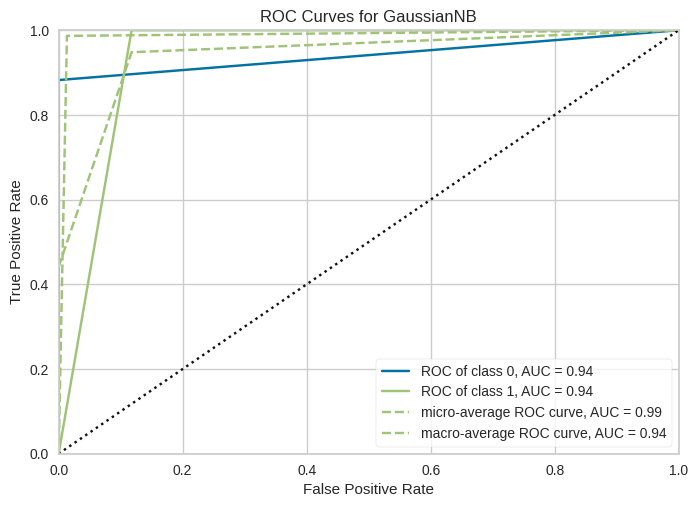

In [ ]:
plot_model(final_model)

In [ ]:
import pickle

# Сохранение модели в файл
with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)

In [ ]:

from mlflow.pyfunc import PythonModel
import pickle

# Определение класса-обертки для модели, загруженной из файла
class PickleModelWrapper(PythonModel):
    def __init__(self, model_path):
        self.model_path = model_path

    def load_context(self, context):
        with open(self.model_path, "rb") as f:
            self.model = pickle.load(f)

    def predict(self, context, model_input):
        return self.model.predict(model_input)

# Путь к файлу с моделью
model_path = "model.pkl"

# Логирование модели в MLflow
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run():
    # Создание экземпляра класса-обертки и логирование модели
    model_wrapper = PickleModelWrapper(model_path)
    mlflow.pyfunc.log_model("model", python_model=model_wrapper)





In [ ]:
import mlflow

# Загрузка эксперимента по имени
experiment = mlflow.get_experiment_by_name("your_experiment_name")
experiment_id = experiment.experiment_id

# Получение списка запусков (runs) для данного эксперимента
runs = mlflow.search_runs(experiment_ids=[experiment_id])

# Просмотр метрик для каждого запуска
for run in runs.iterrows():
    run_id = run[1]['run_id']
    metrics = mlflow.get_run(run_id).data.metrics
    print("Metrics for run:", run_id)
    for metric_name, metric_value in metrics.items():
        print(metric_name, ":", metric_value)


AttributeError: 'NoneType' object has no attribute 'experiment_id'

# Word2Vec

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient

In [ ]:
# Базовые
import os
import time
import numpy as np

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Предварительная обработка данных
import re
import spacy
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from concurrent.futures import ProcessPoolExecutor
from sklearn.model_selection import train_test_split


In [ ]:
# Шаг 1: Загрузка данных в PyCaret
import pandas as pd
from pycaret.classification import *

# Загрузка данных
from pycaret.datasets import get_data
data = get_data('amazon')

# Шаг 2: Предварительная обработка текста
# Пример предварительной обработки текста (можно доработать по вашему усмотрению)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление пунктуации
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Токенизация
    tokens = word_tokenize(text)
    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Применение предобработки к столбцу с отзывами
data['processed_reviews'] = data['reviewText'].apply(preprocess_text)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(data['processed_reviews'])

# Преобразуем полученную матрицу в DataFrame и объединим с исходными данными
X_df = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
data_processed = pd.concat([data, X_df], axis=1)





,reviewText,Positive
0,This is a one of the best apps acording to a b...,1
1,This is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Шаг 3: Использование PyCaret для классификации
# Инициализация PyCaret и создание эксперимента
exp = setup(data=data_processed, target='Positive', session_id=123,fix_imbalance=True, fold_strategy='batch')

# Сравнение нескольких моделей
best_model = compare_models()

# Обучение модели
final_model = finalize_model(best_model)

# Визуализация результатов
plot_model(final_model, plot='confusion_matrix')

In [ ]:
from pycaret.datasets import get_data
data = get_data('amazon')

In [ ]:
def print_short_summary(name, data):
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2 Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()

In [ ]:
print_short_summary(data, data)

In [ ]:
# Построим горизонтальную гистограмму количества записей в классе
plt.figure(figsize=(16, 9))
tmp = data['Positive'].value_counts()
sns.barplot(y=tmp.index.values, x=tmp.values, orient='h')
plt.xlabel('Number of records')
plt.ylabel('Disaster')
plt.title('Number of records per class')
plt.show()

In [ ]:
def plot_word_dist_class(labels, top_n_words = 20):
    """
    Диаграммы с частотой слов для каждого класса.

    Args:
        labels: список классов
        top_n_words (opt): сколько самых популярных слов отображать на одной диаграмме.
    """
    n = len(labels)

    # sns
    default_palette = sns.color_palette("deep")

    # Инициализация подграфики с 1 строкой и n столбцами
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(16, 9))

    # Отобразите количество слов на автора в соответствующих строках.
    for i in range(n):
        col = i % n
        indexes = data['Positive'] == labels[i]
        w = data['reviewText'][indexes].str.split(expand=True).unstack().value_counts()
        l = w[:top_n_words]/np.sum(w)*100
        axes[col].bar(l.index, l.values, color=default_palette[i])
        axes[col].set_title(labels[i])
        axes[col].set_xlabel('Words')
        axes[col].set_ylabel('Percentage of total word count (%)')

    plt.tight_layout()
    plt.show()


In [ ]:
# Частоты слов по классам
plot_word_dist_class([0,1])

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
# Загрузить английские леммы
spacy_process = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Скомпилировать шаблон регулярного выражения
pattern = re.compile(r'\b([a-zA-Z])\b')

# Установите английские стоп-слова, такие как
stop_words = set(stopwords.words('english'))

In [ ]:
def get_processed_text(text):
    """
    Возвращает лемматизированный текст без отдельных букв и частых стоп-слов.
    Все в нижнем регистре.

    Args:
        text (str): текст статьи
    Returns:
        string: текст чистых лемм
    """
    # Преобразовать в строчные одиночные буквы
    text = pattern.sub('', text.lower())

    # Получить лемма токены
    lemmas = spacy_process(text)
    lemmas = [token.lemma_ for token in lemmas if token.text not in stop_words]

    return ' '.join(lemmas)

def get_clean_text(texts):
    """
    Возврат списка очищенных текстов.
    Выполнение параллельное.

    Args:
        texts: пустой массив строковых элементов
    Returns:
        list: список очищенных лемматизированных токенов
    """
    # Настроить параллельную обработку задач Пул процессов
    with ProcessPoolExecutor() as executor:
        clean_texts = list(executor.map(get_processed_text, texts))

    return clean_texts

In [ ]:
# Получим очищенные данные тренировочного и тестового датасета
text_clean = get_clean_text(data['reviewText'].values)

In [ ]:
data_clean = pd.DataFrame({
    'reviewText': text_clean
    , 'Positive': data['Positive'].values
})

In [ ]:
data_clean

In [ ]:
# Получим максимальное количество записей (не катастрофы)
max_count = sum(data_clean['Positive'] == 0)

# Получим минимальное количество записей (катастрофы)
min_count = sum(data_clean['Positive'] == 1)

# Повышение твитов до максимального количества некатастрофических
data_upsampled = []
data_downsampled = []
for i in range(2):
    class_data = data_clean[data_clean['Positive'] == i]
    class_data_up = class_data.sample(max_count
                                     , replace = True
                                     , random_state = 0)
    class_data_down = class_data.sample(min_count
                                     , replace = True
                                     , random_state = 0)
    data_upsampled.append(class_data_up)
    data_downsampled.append(class_data_down)

data_clean_upsamp = pd.concat(data_upsampled)
data_clean_downsamp = pd.concat(data_downsampled)

In [ ]:
# Проверить количество
print('Upsampled data:')
data_clean_upsamp['Positive'].value_counts()

In [ ]:
print('Downsampled data:')
data_clean_downsamp['Positive'].value_counts()

In [ ]:
# Создание и обучение токенов
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_clean['reviewText'].values)

# Преобразовать текст в список указателей слов в корпусе
data_list = [data_clean
             , data_clean_upsamp
             , data_clean_downsamp
            ]
sequences_list = []
for data in data_list:
    sequences_list.append(tokenizer.texts_to_sequences(data['reviewText'].values))

# Получить размер словаря для матрицы
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [ ]:
# Получите максимально доступное количество ядер ЦП для обучения Word2Vec.
workers = os.cpu_count()

# Установить размерность
VECTOR_SIZE = 100

# Создать Word2Vec модель
w2v_model = Word2Vec(sentences = sequences_list[0]
         , vector_size = VECTOR_SIZE
         , window = 3
         , min_count = 1
         , workers = workers)

# Создать матрицу Word2Vec embeddings
EMBED_MATRIX = np.zeros((VOCAB_SIZE, VECTOR_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        EMBED_MATRIX[i] = w2v_model.wv[word]

In [ ]:
from pycaret.classification import *
data_pycaret = data_clean.copy()
clf = setup(data=data_pycaret, target = 'Positive', session_id=123)

In [ ]:
best = compare_models()

In [ ]:
evaluate_model(best)

In [ ]:
predictions = predict_model(best, data=data)
predictions.head()